In [ ]:
Q1.0 Dataset Generation

In [2]:
# Step 1: Imports and seed setup
import numpy as np
import pandas as pd
import hashlib


username = "riya"   
seed = int(hashlib.sha256(username.encode()).hexdigest(), 16) % (2**32)

print("Username:", username)
print("Generated seed:", seed)

Username: riya
Generated seed: 3781250524


In [42]:
# Step 2: Define StudentDataset class
class StudentDataset:
    def __init__(self, num_students: int = 10000, seed: int = None, username: str = "user"):
        """
        Generates the full dataset at initialization.
        You should NOT regenerate data in other cells.
        """
        self.num_students = num_students
        self.seed = seed
        self.username = username

        # Dedicated random number generator for reproducibility
        self.rng = np.random.default_rng(self.seed)

        # Generate all columns
        self.genders = self.generate_gender()
        self.majors = self.generate_major()
        self.programs = self.generate_program(self.majors)
        self.gpa = self.generate_gpa(self.majors)

        # Assemble final DataFrame
        self._df = self.assemble_dataframe()

        # Confirmation message
        print(f"Dataset generated successfully for '{self.username}' with {len(self._df)} students.")

    def get_full_dataframe(self) -> pd.DataFrame:
        """Return the same DataFrame object generated at init."""
        return self._df.copy()

    def generate_gender(self):
        # Male 65%, Female 33%, Other 2%
        choices = ["Male", "Female", "Other"]
        probs = [0.65, 0.33, 0.02]
        return list(self.rng.choice(choices, size=self.num_students, p=probs))

    def generate_major(self):
        # B.Tech 70%, MS 20%, PhD 10%
        choices = ["B.Tech", "MS", "PhD"]
        probs = [0.7, 0.2, 0.1]
        return list(self.rng.choice(choices, size=self.num_students, p=probs))

    def generate_program(self, majors):
        # Program distribution depends on major
        programs = []
        for m in majors:
            if m == "B.Tech":
                probs = [0.4, 0.4, 0.1, 0.1]  # CSE, ECE, CHD, CND
            elif m == "MS":
                probs = [0.3, 0.3, 0.2, 0.2]
            else:  # PhD
                probs = [0.25, 0.25, 0.25, 0.25]
            choices = ["CSE", "ECE", "CHD", "CND"]
            programs.append(self.rng.choice(choices, p=probs))
        return programs

    def generate_gpa(self, majors):
        # GPA ~ Normal(mean, std) per major, clipped to [4.0, 10.0]
        gpas = []
        for m in majors:
            if m == "B.Tech":
                mu, sigma = 7.0, 1.0
            elif m == "MS":
                mu, sigma = 8.0, 0.7
            else:  # PhD
                mu, sigma = 8.3, 0.5
            val = self.rng.normal(mu, sigma)
            gpas.append(float(np.clip(val, 4.0, 10.0)))
        return gpas

    def assemble_dataframe(self):
        # Assemble everything into a single pandas DataFrame
        df = pd.DataFrame({
            "gender": self.genders,
            "major": self.majors,
            "program": self.programs,
            "GPA": self.gpa
        })
        df.index.name = "student_id"
        df.attrs['username'] = self.username
        return df

    # Q1.5: Program-Major Balanced Cohort
    def sample_program_major_balanced(self, n: int) -> pd.DataFrame:
        df = self.get_full_dataframe()
        combos = df.groupby(['program', 'major'])
        num_combos = len(combos)
        samples_per_combo = n // num_combos
        remainder = n % num_combos
        sampled_list = []
        too_small_groups = []

        for name, group in combos:
            replace_flag = len(group) < samples_per_combo
            if replace_flag:
                too_small_groups.append(name)
            sampled = group.sample(samples_per_combo, replace=replace_flag,
                                   random_state=self.rng.integers(0, 1e9))
            sampled_list.append(sampled)

        sampled_df = pd.concat(sampled_list)

        if remainder > 0:
            extra_samples = df.sample(remainder, replace=True,
                                      random_state=self.rng.integers(0, 1e9))
            sampled_df = pd.concat([sampled_df, extra_samples])

        sampled_df = sampled_df.reset_index(drop=True)
        self._too_small_groups = too_small_groups
        return sampled_df

    def show_program_major_counts_and_heatmap(self, sampled_df: pd.DataFrame) -> None:
        counts = sampled_df.groupby(['program', 'major']).size().unstack(fill_value=0)
        print("Counts per (Program, Major):\n", counts)

        plt.figure(figsize=(8,5))
        sns.heatmap(counts, annot=True, fmt='d', cmap='YlGnBu')
        plt.title(f"Program-Major Balanced Cohort Counts ({self.username})")
        plt.ylabel("Program")
        plt.xlabel("Major")
        plt.show()

        if hasattr(self, "_too_small_groups") and self._too_small_groups:
            print("\nWarning: Some (Program, Major) groups were smaller than allocated quota.")
            print("Groups that were too small:", self._too_small_groups)
        else:
            print("\nAll groups had enough students for equal allocation.")


In [4]:
# Step 3: Generate and view dataset
data = StudentDataset(num_students=10000, seed=seed, username=username)
df = data.get_full_dataframe()

# Display first few rows
df.head()


 Dataset generated successfully for 'riya' with 10000 students.


,gender,major,program,GPA
student_id,,,,
0,Male,B.Tech,CSE,6.273679
1,Male,B.Tech,ECE,6.225787
2,Male,B.Tech,ECE,6.565273
3,Male,B.Tech,ECE,7.689523
4,Female,B.Tech,CSE,7.206057


In [5]:
# Number of rows
print("Total students:", len(df))

# Column summary
df.info()

# GPA statistics
print("\nGPA Summary:")
print(df['GPA'].describe())


Total students: 10000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   gender   10000 non-null  object 
 1   major    10000 non-null  object 
 2   program  10000 non-null  object 
 3   GPA      10000 non-null  float64
dtypes: float64(1), object(3)
memory usage: 312.6+ KB

GPA Summary:
count    10000.000000
mean         7.315359
std          1.035647
min          4.000000
25%          6.606783
50%          7.390267
75%          8.093096
max         10.000000
Name: GPA, dtype: float64


In [6]:
#  Step 4: Save as CSV
file_name = "students_dataset.csv"
df.to_csv(file_name, index=True)  # keep index as student_id
print(f" Saved dataset to: {file_name}")


 Saved dataset to: students_dataset.csv


In [7]:
import os
os.path.exists("students_dataset.csv")


True

In [ ]:
Q1.1 Dataset Analysis

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use a nice visual style
sns.set(style="whitegrid", palette="muted")

# helper: add your username to each plot
def add_username_to_plot(username):
    plt.text(
        0.98, 0.98, username,
        ha='right', va='top', transform=plt.gca().transAxes,
        fontsize=10, color='gray', alpha=0.7
    )


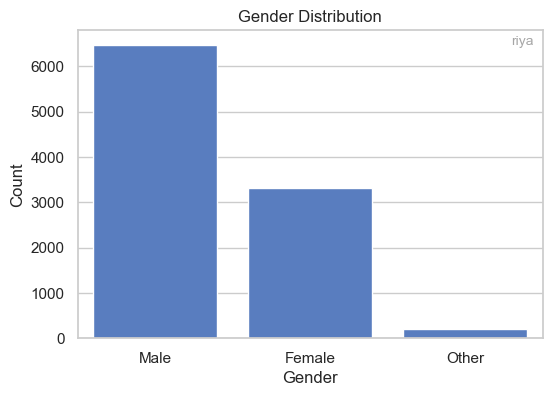

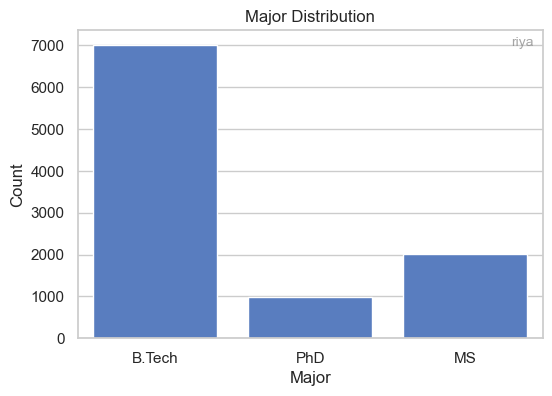

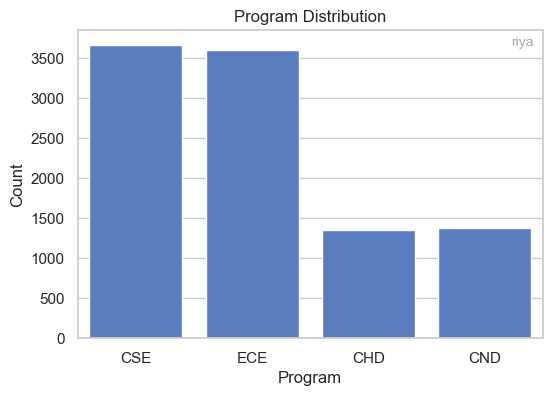

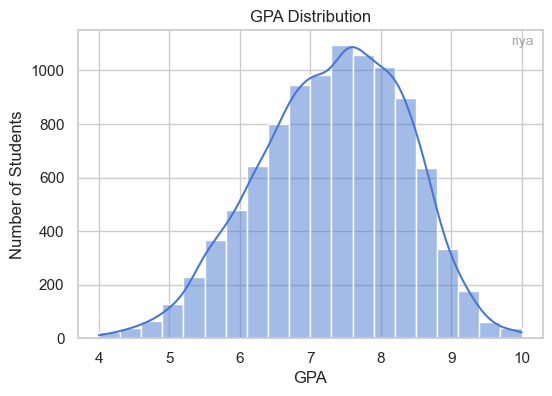

In [9]:
# 1️ Gender distribution
plt.figure(figsize=(6,4))
sns.countplot(x="gender", data=df)
plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Count")
add_username_to_plot(username)
plt.show()

# 2️ Major distribution
plt.figure(figsize=(6,4))
sns.countplot(x="major", data=df)
plt.title("Major Distribution")
plt.xlabel("Major")
plt.ylabel("Count")
add_username_to_plot(username)
plt.show()

# 3️ Program distribution
plt.figure(figsize=(6,4))
sns.countplot(x="program", data=df)
plt.title("Program Distribution")
plt.xlabel("Program")
plt.ylabel("Count")
add_username_to_plot(username)
plt.show()

# 4️ GPA distribution
plt.figure(figsize=(6,4))
sns.histplot(df["GPA"], bins=20, kde=True)
plt.title("GPA Distribution")
plt.xlabel("GPA")
plt.ylabel("Number of Students")
add_username_to_plot(username)
plt.show()


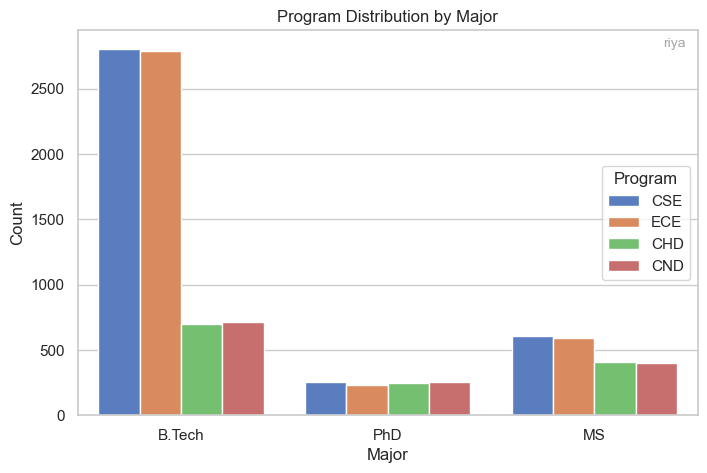

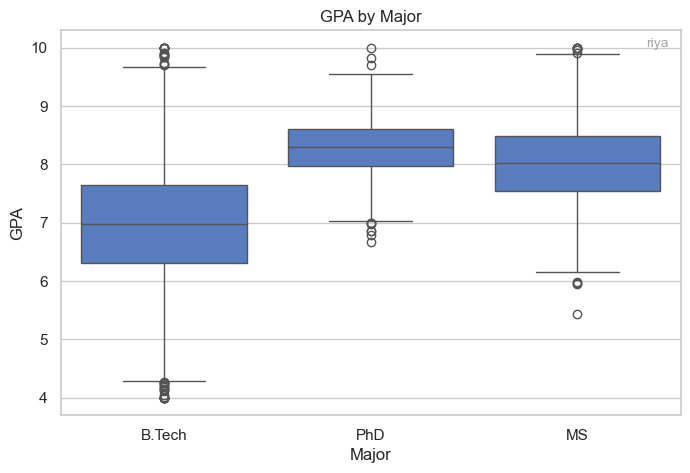

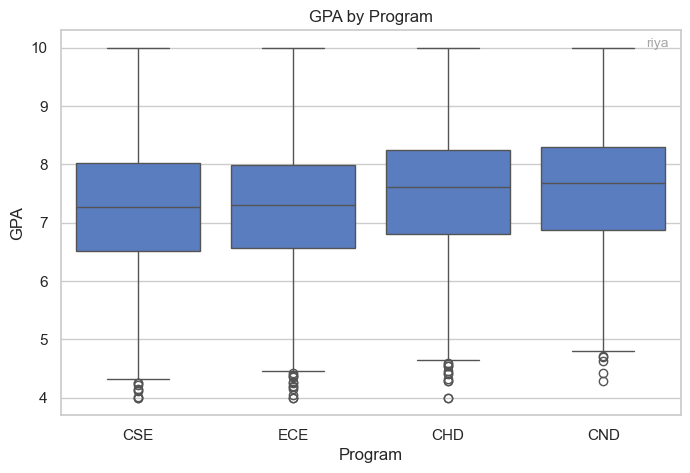

In [10]:
# 5️ Program distribution by Major (stacked bar)
plt.figure(figsize=(8,5))
sns.countplot(x="major", hue="program", data=df)
plt.title("Program Distribution by Major")
plt.xlabel("Major")
plt.ylabel("Count")
add_username_to_plot(username)
plt.legend(title="Program")
plt.show()

# 6️ GPA distribution by Major (boxplot)
plt.figure(figsize=(8,5))
sns.boxplot(x="major", y="GPA", data=df)
plt.title("GPA by Major")
plt.xlabel("Major")
plt.ylabel("GPA")
add_username_to_plot(username)
plt.show()

# 7️ GPA distribution by Program (boxplot)
plt.figure(figsize=(8,5))
sns.boxplot(x="program", y="GPA", data=df)
plt.title("GPA by Program")
plt.xlabel("Program")
plt.ylabel("GPA")
add_username_to_plot(username)
plt.show()


In [11]:
# GPA summary by Major
print(" Average GPA by Major:")
print(df.groupby("major")["GPA"].mean(), "\n")

# GPA summary by Program
print(" Average GPA by Program:")
print(df.groupby("program")["GPA"].mean(), "\n")

# Gender count percentages
print(" Gender Percentage:")
print((df["gender"].value_counts(normalize=True) * 100).round(2))


 Average GPA by Major:
major
B.Tech    6.977264
MS        8.019381
PhD       8.286836
Name: GPA, dtype: float64 

 Average GPA by Program:
program
CHD    7.488635
CND    7.539629
CSE    7.239089
ECE    7.242589
Name: GPA, dtype: float64 

 Gender Percentage:
gender
Male      64.73
Female    33.22
Other      2.05
Name: proportion, dtype: float64


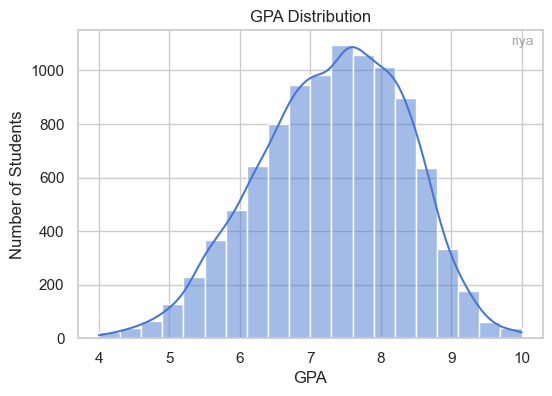

In [12]:
plt.figure(figsize=(6,4))
sns.histplot(df["GPA"], bins=20, kde=True)
plt.title("GPA Distribution")
plt.xlabel("GPA")
plt.ylabel("Number of Students")
add_username_to_plot(username)
plt.savefig("plot_gpa_distribution.png", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
Q1.2 Simple vs Stratified Sampling

In [13]:
import statistics as stats
def random_sampling_mean_std(df, n=500, repeats=50, rng=None):
    means = []
    for _ in range(repeats):
        sample = df.sample(n=n, replace=False, random_state=rng.integers(1e9))
        means.append(sample['GPA'].mean())
    return np.mean(means), np.std(means)


In [14]:
def stratified_sampling_mean_std(df, n=500, repeats=50, rng=None):
    means = []
    # get proportion of each major in full dataset
    proportions = df['major'].value_counts(normalize=True)

    for _ in range(repeats):
        parts = []
        for major, prop in proportions.items():
            k = int(round(prop * n))
            subset = df[df['major'] == major].sample(
                n=k, replace=False, random_state=rng.integers(1e9)
            )
            parts.append(subset)
        sample = pd.concat(parts)

        # adjust if rounding caused off-by-one
        if len(sample) < n:
            extra = df.sample(n=(n - len(sample)), random_state=rng.integers(1e9))
            sample = pd.concat([sample, extra])
        elif len(sample) > n:
            sample = sample.sample(n=n, random_state=rng.integers(1e9))

        means.append(sample['GPA'].mean())

    return np.mean(means), np.std(means)


In [15]:
rng = np.random.default_rng(seed)

# Population mean for reference
population_mean = df['GPA'].mean()

# Random sampling
mean_random, std_random = random_sampling_mean_std(df, n=500, repeats=50, rng=rng)

# Stratified sampling
mean_stratified, std_stratified = stratified_sampling_mean_std(df, n=500, repeats=50, rng=rng)

print(f"Population mean GPA: {population_mean:.3f}")
print(f"Random sampling → mean of sample means = {mean_random:.3f}, std = {std_random:.3f}")
print(f"Stratified sampling → mean of sample means = {mean_stratified:.3f}, std = {std_stratified:.3f}")


Population mean GPA: 7.315
Random sampling → mean of sample means = 7.317, std = 0.040
Stratified sampling → mean of sample means = 7.308, std = 0.038


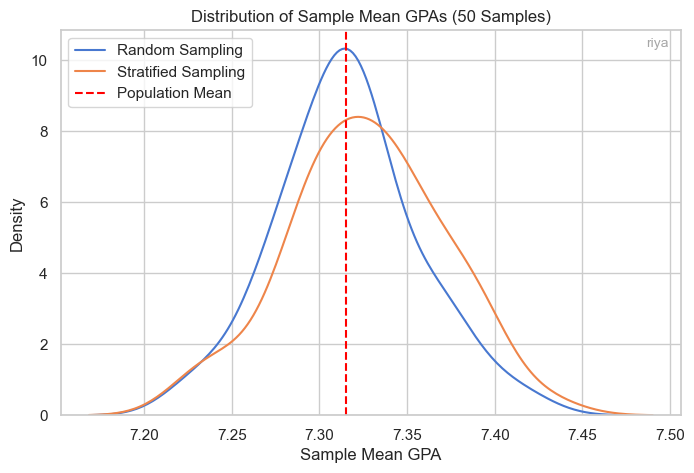

In [16]:
def compare_sampling_distribution(df, n=500, repeats=50, rng=None):
    random_means = []
    strat_means = []
    proportions = df['major'].value_counts(normalize=True)

    for _ in range(repeats):
        s_random = df.sample(n=n, replace=False, random_state=rng.integers(1e9))
        random_means.append(s_random['GPA'].mean())

        parts = []
        for major, prop in proportions.items():
            k = int(round(prop * n))
            parts.append(df[df['major']==major].sample(n=k, replace=False, random_state=rng.integers(1e9)))
        s_strat = pd.concat(parts)
        strat_means.append(s_strat['GPA'].mean())

    plt.figure(figsize=(8,5))
    sns.kdeplot(random_means, label="Random Sampling")
    sns.kdeplot(strat_means, label="Stratified Sampling")
    plt.axvline(df['GPA'].mean(), color='red', linestyle='--', label="Population Mean")
    plt.title("Distribution of Sample Mean GPAs (50 Samples)")
    plt.xlabel("Sample Mean GPA")
    plt.ylabel("Density")
    plt.legend()
    add_username_to_plot(username)
    plt.show()

compare_sampling_distribution(df, n=500, repeats=50, rng=np.random.default_rng(seed))


In [ ]:
Q1.3 Gender-Balanced Cohort

In [17]:
def relative_gender_difference(counts):
    """
    counts: dict or Series with gender counts
    returns: (max - min) / total
    """
    total = sum(counts.values())
    return (max(counts.values()) - min(counts.values())) / total


In [18]:
def sample_gender_balanced(df, n=300, rng=None):
    genders = df['gender'].unique()
    per_group = n // len(genders)
    samples = []
    for g in genders:
        subset = df[df['gender'] == g]
        s = subset.sample(n=per_group, replace=False, random_state=rng.integers(1e9))
        samples.append(s)
    result = pd.concat(samples)
    # if rounding caused <n, fill remainder randomly
    if len(result) < n:
        result = pd.concat([result, df.sample(n=n-len(result), random_state=rng.integers(1e9))])
    return result


In [19]:
def sample_strategy_A(df, n=300, rng=None):
    genders = list(df['gender'].unique())
    selected = []
    for _ in range(n):
        g = rng.choice(genders)          # choose gender uniformly
        s = df[df['gender'] == g].sample(n=1, random_state=rng.integers(1e9))
        selected.append(s)
    return pd.concat(selected)


In [24]:
#  Helper function
def relative_gender_difference(counts):
    values = counts.values
    total = values.sum()
    return (values.max() - values.min()) / total


# Fixed sampling function
def sample_gender_balanced(df, n=300, rng=None):
    """
    Sample equal number of students from each gender.
    If a gender group has fewer members than required, sample with replacement.
    """
    genders = df['gender'].unique()
    per_group = n // len(genders)
    samples = []
    for g in genders:
        subset = df[df['gender'] == g]
        #  Fix: handle small 'Other' gender by allowing replacement
        replace_flag = len(subset) < per_group
        s = subset.sample(n=per_group, replace=replace_flag,
                          random_state=int(rng.integers(1e9)))
        samples.append(s)
    result = pd.concat(samples)

    #  Fix: if total < n due to rounding, add extra random samples
    if len(result) < n:
        extra = df.sample(n=(n - len(result)), replace=False,
                          random_state=int(rng.integers(1e9)))
        result = pd.concat([result, extra])
    return result


#  Main experiment
rng = np.random.default_rng(seed)

sample_sizes = [100, 200, 400, 600, 800, 1000]
repeats = 50

avg_diff_balanced = []
avg_diff_strategyA = []

for n in sample_sizes:
    diffs_bal = []
    diffs_A = []
    for _ in range(repeats):
        s_bal = sample_gender_balanced(df, n=n, rng=rng)
        s_A   = sample_strategy_A(df, n=n, rng=rng)

        counts_bal = s_bal['gender'].value_counts()
        counts_A   = s_A['gender'].value_counts()

        diffs_bal.append(relative_gender_difference(counts_bal))
        diffs_A.append(relative_gender_difference(counts_A))

    avg_diff_balanced.append(np.mean(diffs_bal))
    avg_diff_strategyA.append(np.mean(diffs_A))

print(" Done! Balanced:", np.round(avg_diff_balanced, 4))
print(" Done! Strategy A:", np.round(avg_diff_strategyA, 4))


 Done! Balanced: [0.01   0.0076 0.0025 0.     0.002  0.001 ]
 Done! Strategy A: [0.094  0.0622 0.048  0.0375 0.0354 0.0334]


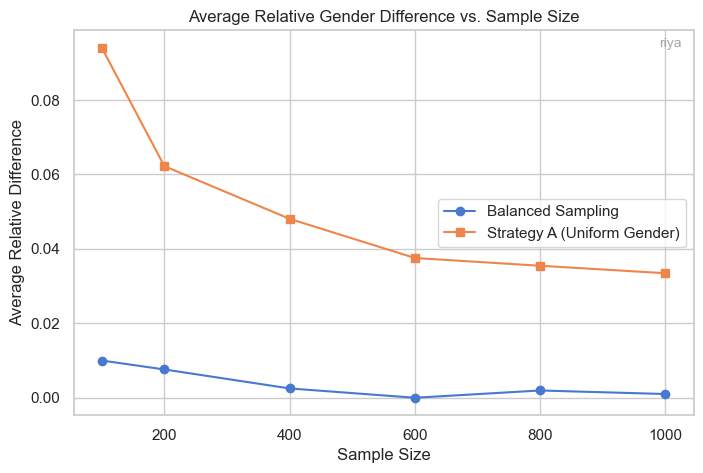

In [25]:
plt.figure(figsize=(8,5))
plt.plot(sample_sizes, avg_diff_balanced, 'o-', label="Balanced Sampling")
plt.plot(sample_sizes, avg_diff_strategyA, 's-', label="Strategy A (Uniform Gender)")
plt.title("Average Relative Gender Difference vs. Sample Size")
plt.xlabel("Sample Size")
plt.ylabel("Average Relative Difference")
plt.legend()
add_username_to_plot(username)
plt.show()


In [26]:
for n, dA in zip(sample_sizes, avg_diff_strategyA):
    print(f"Sample size {n}: Strategy A avg difference = {dA:.3f}")


Sample size 100: Strategy A avg difference = 0.094
Sample size 200: Strategy A avg difference = 0.062
Sample size 400: Strategy A avg difference = 0.048
Sample size 600: Strategy A avg difference = 0.038
Sample size 800: Strategy A avg difference = 0.035
Sample size 1000: Strategy A avg difference = 0.033


In [ ]:
Q1.4 GPA-Uniform Cohort

In [27]:
import pandas as pd
import numpy as np

# Sample GPA data
data = pd.DataFrame({
    'StudentID': range(1, 21),
    'GPA': [7.2, 8.5, 6.8, 7.9, 8.2, 9.0, 6.5, 7.5, 8.8, 7.1,
            7.3, 8.0, 9.2, 6.9, 7.8, 8.1, 6.7, 7.6, 8.4, 9.1]
})

# Divide GPA into 4 bins (quartiles)
bins = [0, 7, 8, 9, 10]  # GPA ranges
labels = ['Low', 'Medium', 'High', 'Very High']

data['GPA_bin'] = pd.cut(data['GPA'], bins=bins, labels=labels)
print(data)


    StudentID  GPA    GPA_bin
0           1  7.2     Medium
1           2  8.5       High
2           3  6.8        Low
3           4  7.9     Medium
4           5  8.2       High
5           6  9.0       High
6           7  6.5        Low
7           8  7.5     Medium
8           9  8.8       High
9          10  7.1     Medium
10         11  7.3     Medium
11         12  8.0     Medium
12         13  9.2  Very High
13         14  6.9        Low
14         15  7.8     Medium
15         16  8.1       High
16         17  6.7        Low
17         18  7.6     Medium
18         19  8.4       High
19         20  9.1  Very High


In [29]:
import warnings
warnings.filterwarnings('ignore')
# Number of samples per bin
samples_per_bin = 2

# Sample uniformly from each bin
sampled_data = data.groupby('GPA_bin', group_keys=False).apply(lambda x: x.sample(samples_per_bin))
print(sampled_data)


    StudentID  GPA    GPA_bin
6           7  6.5        Low
2           3  6.8        Low
11         12  8.0     Medium
17         18  7.6     Medium
15         16  8.1       High
18         19  8.4       High
12         13  9.2  Very High
19         20  9.1  Very High


In [33]:
sample_with_replacement = data.groupby('GPA_bin', group_keys=False)\
                              .apply(lambda x: x.sample(samples_per_bin, replace=True))

print("=== Sample WITH Replacement ===")
print(sample_with_replacement)

=== Sample WITH Replacement ===
    StudentID  GPA    GPA_bin
16         17  6.7        Low
6           7  6.5        Low
14         15  7.8     Medium
17         18  7.6     Medium
8           9  8.8       High
1           2  8.5       High
12         13  9.2  Very High
19         20  9.1  Very High


In [34]:
sample_without_replacement = data.groupby('GPA_bin', group_keys=False)\
                                 .apply(lambda x: x.sample(samples_per_bin, replace=False))

print("\n=== Sample WITHOUT Replacement ===")
print(sample_without_replacement)


=== Sample WITHOUT Replacement ===
    StudentID  GPA    GPA_bin
13         14  6.9        Low
16         17  6.7        Low
9          10  7.1     Medium
14         15  7.8     Medium
1           2  8.5       High
15         16  8.1       High
12         13  9.2  Very High
19         20  9.1  Very High


In [ ]:
Q1.5 Program Major Balanced Cohort

In [35]:
import hashlib
import numpy as np

# Example: replace with your IIITH email username (before @)
username = "riya"

# SHA-256 hash to integer, modulo 2**32
seed = int(hashlib.sha256(username.encode()).hexdigest(), 16) % (2**32)

# Create random generator
rng = np.random.default_rng(seed)


In [36]:
def sample_program_major_balanced(self, n: int) -> pd.DataFrame:
    """
    Sample 'n' students such that all valid (Program, Major) combinations
    are represented approximately equally using Sampling Strategy A.
    Sampling is reproducible using the pre-defined seed.
    """
    df = self.get_full_dataframe()
    
    # Group by (Program, Major)
    combos = df.groupby(['Program', 'Major'])
    num_combos = len(combos)
    
    # Samples per combination
    samples_per_combo = n // num_combos
    remainder = n % num_combos
    
    sampled_list = []
    too_small_groups = []

    for name, group in combos:
        replace_flag = len(group) < samples_per_combo
        if replace_flag:
            too_small_groups.append(name)
        # Use random_state=rng.integers(0, 1e9) for reproducibility
        sampled = group.sample(samples_per_combo, replace=replace_flag, random_state=rng.integers(0, 1e9))
        sampled_list.append(sampled)
    
    sampled_df = pd.concat(sampled_list)
    
    # Fill remainder
    if remainder > 0:
        extra_samples = df.sample(remainder, replace=True, random_state=rng.integers(0, 1e9))
        sampled_df = pd.concat([sampled_df, extra_samples])
    
    sampled_df = sampled_df.reset_index(drop=True)
    self._too_small_groups = too_small_groups
    
    return sampled_df


In [37]:
def show_program_major_counts_and_heatmap(self, sampled_df: pd.DataFrame) -> None:
    counts = sampled_df.groupby(['Program', 'Major']).size().unstack(fill_value=0)
    print("Counts per (Program, Major):\n", counts)
    
    plt.figure(figsize=(8,5))
    sns.heatmap(counts, annot=True, fmt='d', cmap='YlGnBu')
    plt.title(f"Program-Major Balanced Cohort Counts ({username})")
    plt.ylabel("Program")
    plt.xlabel("Major")
    plt.show()
    
    if hasattr(self, "_too_small_groups") and self._too_small_groups:
        print("\nWarning: Some (Program, Major) groups were smaller than allocated quota.")
        print("Groups that were too small:", self._too_small_groups)
    else:
        print("\nAll groups had enough students for equal allocation.")


Dataset generated successfully for 'user' with 10000 students.
Counts per (Program, Major):
 major    B.Tech  MS  PhD
program                 
CHD           5   5    5
CND           5   5    5
CSE           5   5    5
ECE           5   5    5


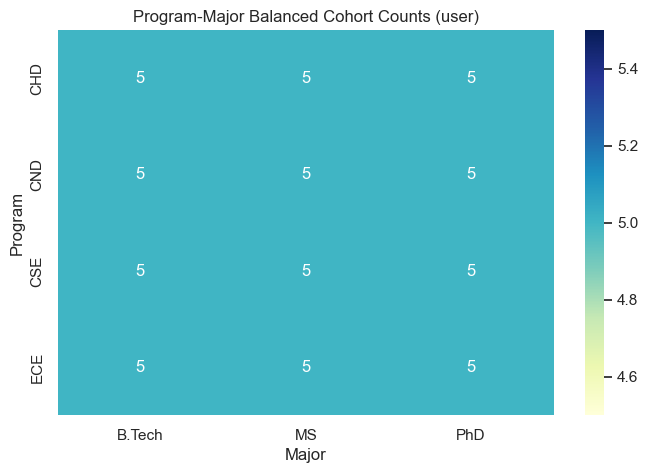


All groups had enough students for equal allocation.


In [43]:
# Assuming StudentDataset object exists
dataset = StudentDataset(num_students=10000, seed=seed)

# Q1.5: Program-Major Balanced Cohort
sampled_pm = dataset.sample_program_major_balanced(n=60)
dataset.show_program_major_counts_and_heatmap(sampled_pm)

